In [1]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

# dask 
from dask.diagnostics import ProgressBar

### plotting 
from matplotlib import pyplot as plt


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


### directory with the daily GPM-IMERG data (one file per day )

In [3]:
dpath = pathlib.Path('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP')

In [4]:
lfiles = list(dpath.glob("GPM_IMERG_daily.v06.????.??.??.nc"))

In [5]:
lfiles.sort()

In [6]:
lfiles[0]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2001.01.01.nc')

In [7]:
lfiles[-1]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2021.09.26.nc')

In [8]:
len(lfiles)

7574

### open the multiple file dataset and selects the variable of interest 

In [9]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', parallel=True)[['precipitationCal']]

### calculates the running accumulations 

### re-chunks first 

In [10]:
dset = dset.chunk({'time':-1, 'lon':10, 'lat':10})

### number of days 

In [11]:
ndays = 90

### running accumulation 

In [12]:
dset = dset.rolling({'time':ndays}, min_periods=ndays, center=False).sum('time')

In [13]:
with ProgressBar(): 
    dset = dset.compute()

[########################################] | 100% Completed |  1min  1.7s


### get rid of the ndays - 1 first values (missing values)

In [14]:
dset = dset.isel(time=slice(ndays-1, None))

### take the month and day of the last value 

In [15]:
day = dset.time.to_index()[-1].day

In [16]:
month = dset.time.to_index()[-1].month

In [17]:
day

26

In [18]:
month

9

### buffer (in days) around the date (for taking the corresponding accumulations from the climatology)

In [19]:
buffer = 3

### climatological period 

In [20]:
clim_period =[2001, 2020]

## construct dates 

In [21]:
ldates = []
for y in np.arange(clim_period[0], clim_period[-1] + 1): 
    d = datetime(y, month, day)
    d = [d + relativedelta(days=x) for x in range(-buffer, buffer+1)]
    ldates += d

In [22]:
ldates = np.array(ldates)

In [23]:
dates = pd.Index(ldates)

In [24]:
dates = dates.to_series()

In [25]:
clim = dset.sel(time=slice(*map(str, clim_period)))

In [26]:
clim['time'] = clim.indexes['time'].to_datetimeindex()

<ipython-input-26-69a656c69746>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clim['time'] = clim.indexes['time'].to_datetimeindex()


In [27]:
dates = dates.loc[clim.time.to_index()[0]:clim.time.to_index()[-1],]

In [28]:
clim = clim.sel(time=dates.values)

In [29]:
clim.time[:5]

<xarray.DataArray 'time' (time: 5)>
array(['2001-09-23T00:00:00.000000000', '2001-09-24T00:00:00.000000000',
       '2001-09-25T00:00:00.000000000', '2001-09-26T00:00:00.000000000',
       '2001-09-27T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-09-23 2001-09-24 ... 2001-09-27

In [30]:
clim.time[-5:]

<xarray.DataArray 'time' (time: 5)>
array(['2020-09-25T00:00:00.000000000', '2020-09-26T00:00:00.000000000',
       '2020-09-27T00:00:00.000000000', '2020-09-28T00:00:00.000000000',
       '2020-09-29T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-09-25 2020-09-26 ... 2020-09-29

In [31]:
ds_In = np.log(clim)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [32]:
ds_In = ds_In.where(~np.isinf(ds_In)) 

In [33]:
ds_mu = clim.mean('time')

In [34]:
ds_sum = ds_In.sum('time')

In [35]:
n = len(ds_In.time)

In [36]:
A = np.log(ds_mu) - (ds_sum/n) 

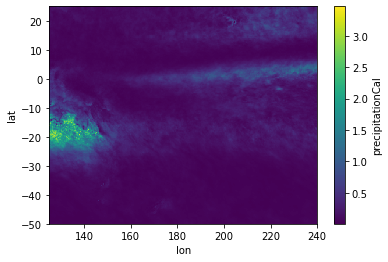

In [37]:
A['precipitationCal'].plot()

In [38]:
alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)

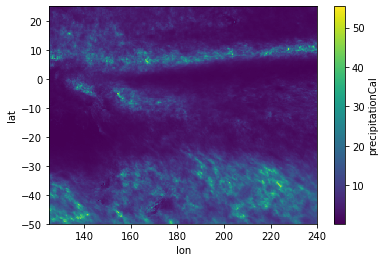

In [39]:
alpha['precipitationCal'].plot()

In [40]:
beta = ds_mu/alpha

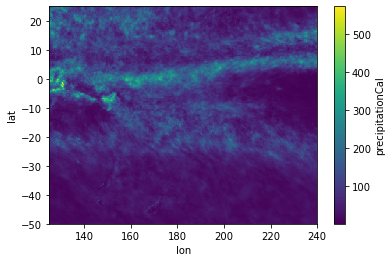

In [41]:
beta['precipitationCal'].plot()

### calculates the SPI for one grid point 

In [42]:
from scipy import stats as st

In [43]:
gamma_clim = st.gamma.cdf(clim['precipitationCal'].data[:,0,0], a=alpha['precipitationCal'].data[0,0], scale=beta['precipitationCal'].data[0,0]) 

### calculates the CDF for the latest value (from the `dset` dataset)

In [44]:
gamma_realtime = st.gamma.cdf(dset['precipitationCal'].data[-1,0,0], a=alpha['precipitationCal'].data[0,0], scale=beta['precipitationCal'].data[0,0]) 

In [45]:
norm_spi_clim = st.norm.ppf(gamma_clim, loc=0, scale=1)

In [46]:
norm_spi_realtime = st.norm.ppf(gamma_realtime, loc=0, scale=1)

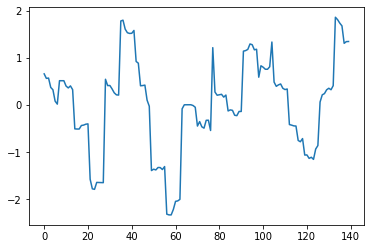

In [47]:
plt.plot(norm_spi_clim)

In [48]:
norm_spi_realtime

-0.09525629705757863

### now calculates the SPI for all grid points 

In [49]:
gamma_clim = np.empty_like(clim['precipitationCal'].data) 

In [50]:
gamma_realtime = np.empty_like(dset['precipitationCal'].data[-1,...]) 

In [51]:
for ilat in range(len(clim.lat)): 
    for ilon in range(len(clim.lon)): 
        gamma_clim[:,ilat,ilon] = st.gamma.cdf(clim['precipitationCal'].data[:,ilat,ilon], a=alpha['precipitationCal'].data[ilat,ilon], scale=beta['precipitationCal'].data[ilat,ilon])
        gamma_realtime[ilat, ilon] = st.gamma.cdf(clim['precipitationCal'].data[-1,ilat,ilon], a=alpha['precipitationCal'].data[ilat,ilon], scale=beta['precipitationCal'].data[ilat,ilon])

In [52]:
gamma_clim.shape

(140, 300, 460)

In [53]:
gamma_realtime.shape

(300, 460)

In [54]:
SPI_clim = np.apply_along_axis(st.norm.ppf, 0, gamma_clim, **{'loc':0, 'scale':1})

In [55]:
SPI_clim.shape

(140, 300, 460)

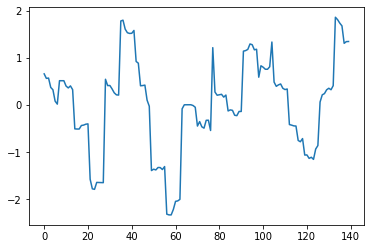

In [56]:
plt.plot(SPI_clim[:,0,0])

In [57]:
SPI_realtime = st.norm.ppf(gamma_realtime, loc=0, scale=1)

In [58]:
SPI_realtime[0,0]

1.3474642794665013

In [59]:
SPI_realtime

array([[ 1.34746428,  1.34149316,  1.18695057, ..., -0.48255096,
        -0.42203242, -0.4420907 ],
       [ 1.1591211 ,  1.28855217,  1.01858424, ..., -0.55178118,
        -0.69063372, -0.76805449],
       [ 1.2349433 ,  1.08919995,  0.79425129, ..., -0.63762006,
        -0.81420387, -0.77012168],
       ...,
       [ 0.47660317,  0.60189102,  0.48614702, ..., -0.97904147,
        -0.8181046 , -0.53837769],
       [ 0.51860771,  0.73832366,  0.77802594, ..., -0.73789786,
        -0.56338609, -0.47670676],
       [ 0.58665139,  0.61194171,  0.99999769, ..., -0.29532453,
        -0.24196486, -0.2902513 ]])

In [60]:
dset['SPI'] = (('lat','lon'), SPI_realtime)

In [61]:
import sys

In [62]:
sys.path.append('../../')

In [63]:
from ICU_Water_Watch import plot

In [64]:
from ICU_Water_Watch.plot import * 

In [65]:
thresholds = [-2.5, -2, -1.5, -1, 1, 1.5, 2, 2.5]

rgbs = ['#f54842', '#de8735', '#deb42a', '#ffffff', '#96ceff', '#4553bf', '#09146b']

ticks_marks = np.diff(np.array(thresholds)) / 2.

ticks = [thresholds[i] + ticks_marks[i] for i in range(len(thresholds) - 1)]

In [66]:
ticks

[-2.25, -1.75, -1.25, 0.0, 1.25, 1.75, 2.25]

In [67]:
cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'neither', 'drawedges':True, 'ticks':ticks, 'aspect':15}

In [68]:
cmap = matplotlib.colors.ListedColormap(rgbs, name='SPI')

In [69]:
dataarray = dset['SPI']

In [70]:
cbar_ticklabels = ['extremely\ndry','severely\dry','moderately\ndry',' ', 'moderately\nwet','severely\nwet','extremely\nwet']

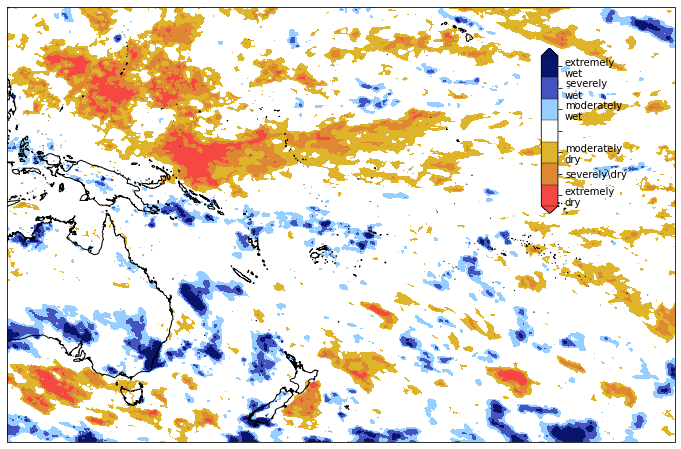

In [71]:
f, ax = plt.subplots(figsize=(13, 8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

im = dataarray.plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

# adds the colorbar axes as insets 

cbar_ax = ax.axes.inset_axes([0.80, 0.525, 0.025, 0.38])

# plots the colorbar in these axes 

cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off() 

# plots the ticklabels 

cbar_ax.set_yticklabels(cbar_ticklabels)

ax.coastlines(resolution='10m')

In [72]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [73]:
#Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    
    ds_mu = ds_ma.mean(dimension)
    
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)
    
    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF) 
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

In [91]:
ds_ma = clim['precipitationCal']

In [92]:
dimension='time'

In [93]:
ds_In = np.log(ds_ma)
ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN

ds_mu = ds_ma.mean(dimension)

#Overall Mean of Moving Averages
ds_mu = ds_ma.mean(dimension)

#Summation of Natural log of moving averages
ds_sum = ds_In.sum(dimension)

#Computing essentials for gamma distribution
n = ds_In.count(dimension)                  #size of data
A = np.log(ds_mu) - (ds_sum/n)             #Computing A
alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
beta = ds_mu/alpha            

In [94]:
gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)

In [95]:
gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)

In [97]:
gamma_realtime = xr.apply_ufunc(gamma_func, dset['precipitationCal'][-1,:,:], alpha, beta)

In [98]:
norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)

In [99]:
norm_spi = xr.apply_ufunc(norminv, gamma)

In [100]:
norm_spi_realtime = xr.apply_ufunc(norminv, gamma_realtime)

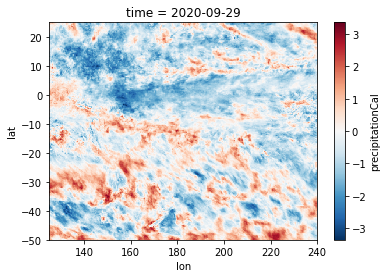

In [101]:
norm_spi[-1,:,:].plot()

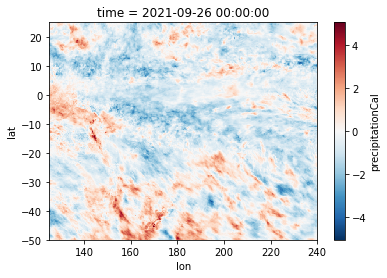

In [103]:
norm_spi_realtime.plot()

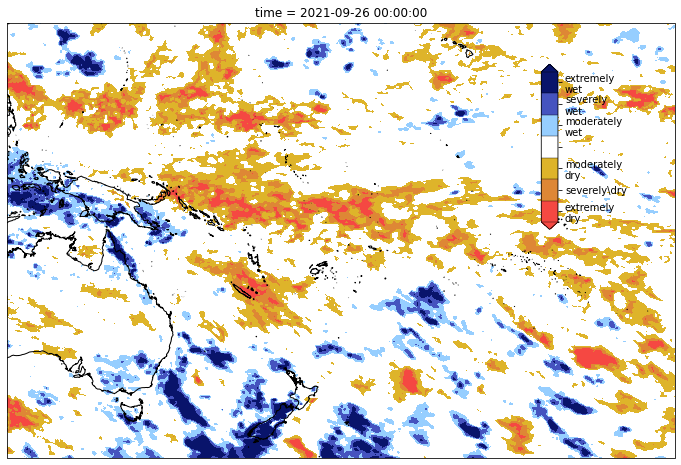

In [104]:
f, ax = plt.subplots(figsize=(13, 8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

im = norm_spi_realtime.plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

# adds the colorbar axes as insets 

cbar_ax = ax.axes.inset_axes([0.80, 0.525, 0.025, 0.38])

# plots the colorbar in these axes 

cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off() 

# plots the ticklabels 

cbar_ax.set_yticklabels(cbar_ticklabels)

ax.coastlines(resolution='10m')